In [2]:
import datetime
import json
import boto3
import io
import numpy as np
import pandas as pd
import pandas_datareader.data as web
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import matplotlib.dates as mdates
#import seaborn as sns
plt.style.use('ggplot')

In [3]:
pickle_file = '../btc-autotrader/lib/data/log/2019-04-16T17:22:23.325492.pickle'

In [4]:
df = pd.read_pickle(pickle_file)

In [5]:
df.head()

,datetime,cash,cash_orig,btc_in_possession,btc_current_price,position,rate_of_change,total_value,acceleration,bid_high,ask_low,mid_price,bought_price,sold_price,target_price,size
0,2019-04-16 17:22:28.618931,33758.0,0,0.004693,567294.0,0,None,0,None,567293.0,567891.0,567592.0,0,0,0,0
0,2019-04-16 17:22:33.638229,33758.0,0,0.004693,567294.0,0,0.553677,0,None,567293.0,567886.0,567589.0,0,0,0,0
0,2019-04-16 17:22:38.652754,33758.0,0,0.004693,567292.0,0,0.553677,0,0,567314.0,567887.0,567600.0,0,0,0,0
0,2019-04-16 17:22:43.669138,28079.0,0,0.014681,567887.0,2,0.465297,0,-0.0176222,567315.0,567883.0,567599.0,567883,0,0,0
0,2019-04-16 17:22:48.681414,28079.0,0,0.004667,567314.0,3,0.387762,0,-0.0154348,567327.0,567877.0,567602.0,567883,0,0,0


In [6]:
df['spread'] = df.ask_low - df.bid_high

In [7]:
df['spread_pct_change'] = df.spread.pct_change()

In [8]:
df.loc[df.rate_of_change >= 0, 'rate_of_change_positive'] = 1
df.loc[df.rate_of_change < 0, 'rate_of_change_positive'] = -1
df.loc[df.rate_of_change >= 5, 'rate_of_change_positive'] = 2
df.loc[df.rate_of_change < -5, 'rate_of_change_positive'] = -2

In [9]:
df['btc_current_price_normalized'] = (df.btc_current_price - df.btc_current_price.mean()) / df.btc_current_price.std()


In [10]:
df['returns'] = np.log(df['btc_current_price']/df['btc_current_price'].shift(1))

In [11]:
df['strategy'] = df['rate_of_change_positive'].shift(1) * df['returns']

In [12]:
df.tail()

,datetime,cash,cash_orig,btc_in_possession,btc_current_price,position,rate_of_change,total_value,acceleration,bid_high,...,bought_price,sold_price,target_price,size,spread,spread_pct_change,rate_of_change_positive,btc_current_price_normalized,returns,strategy
0,2019-04-16 17:27:44.727176,28075.0,0,0.014655,567172.0,4,-0.967262,0,0,567168.0,...,568297,567979,0,0,825.0,-0.002418,-1.0,-1.000747,0.000000,-0.000000
0,2019-04-16 17:27:49.745872,28075.0,0,0.004641,567167.0,3,-0.967262,0,0,567167.0,...,568297,567979,0,0,824.0,-0.001212,-1.0,-1.019211,-0.000009,0.000009
0,2019-04-16 17:27:54.758994,28075.0,0,0.004641,567167.0,3,-1.1008,0,-0.0266155,567168.0,...,568297,567979,0,0,817.0,-0.008495,-1.0,-1.019211,0.000000,-0.000000
0,2019-04-16 17:27:59.774396,28075.0,0,0.014655,567167.0,4,-1.1008,0,0,567189.0,...,568297,567979,0,0,802.0,-0.018360,-1.0,-1.019211,0.000000,-0.000000
0,2019-04-16 17:28:04.790598,28075.0,0,0.004641,567994.0,4,-1.1008,0,0,567171.0,...,568297,567979,0,0,820.0,0.022444,-1.0,2.034729,0.001457,-0.001457


In [13]:
np.exp(df[['returns', 'strategy']].sum())

returns     1.001234
strategy    0.999356
dtype: float64

/Users/soichi/.pyenv/versions/3.7.1/envs/finance-stats/lib/python3.7/site-packages/pandas/plotting/_converter.py:129: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


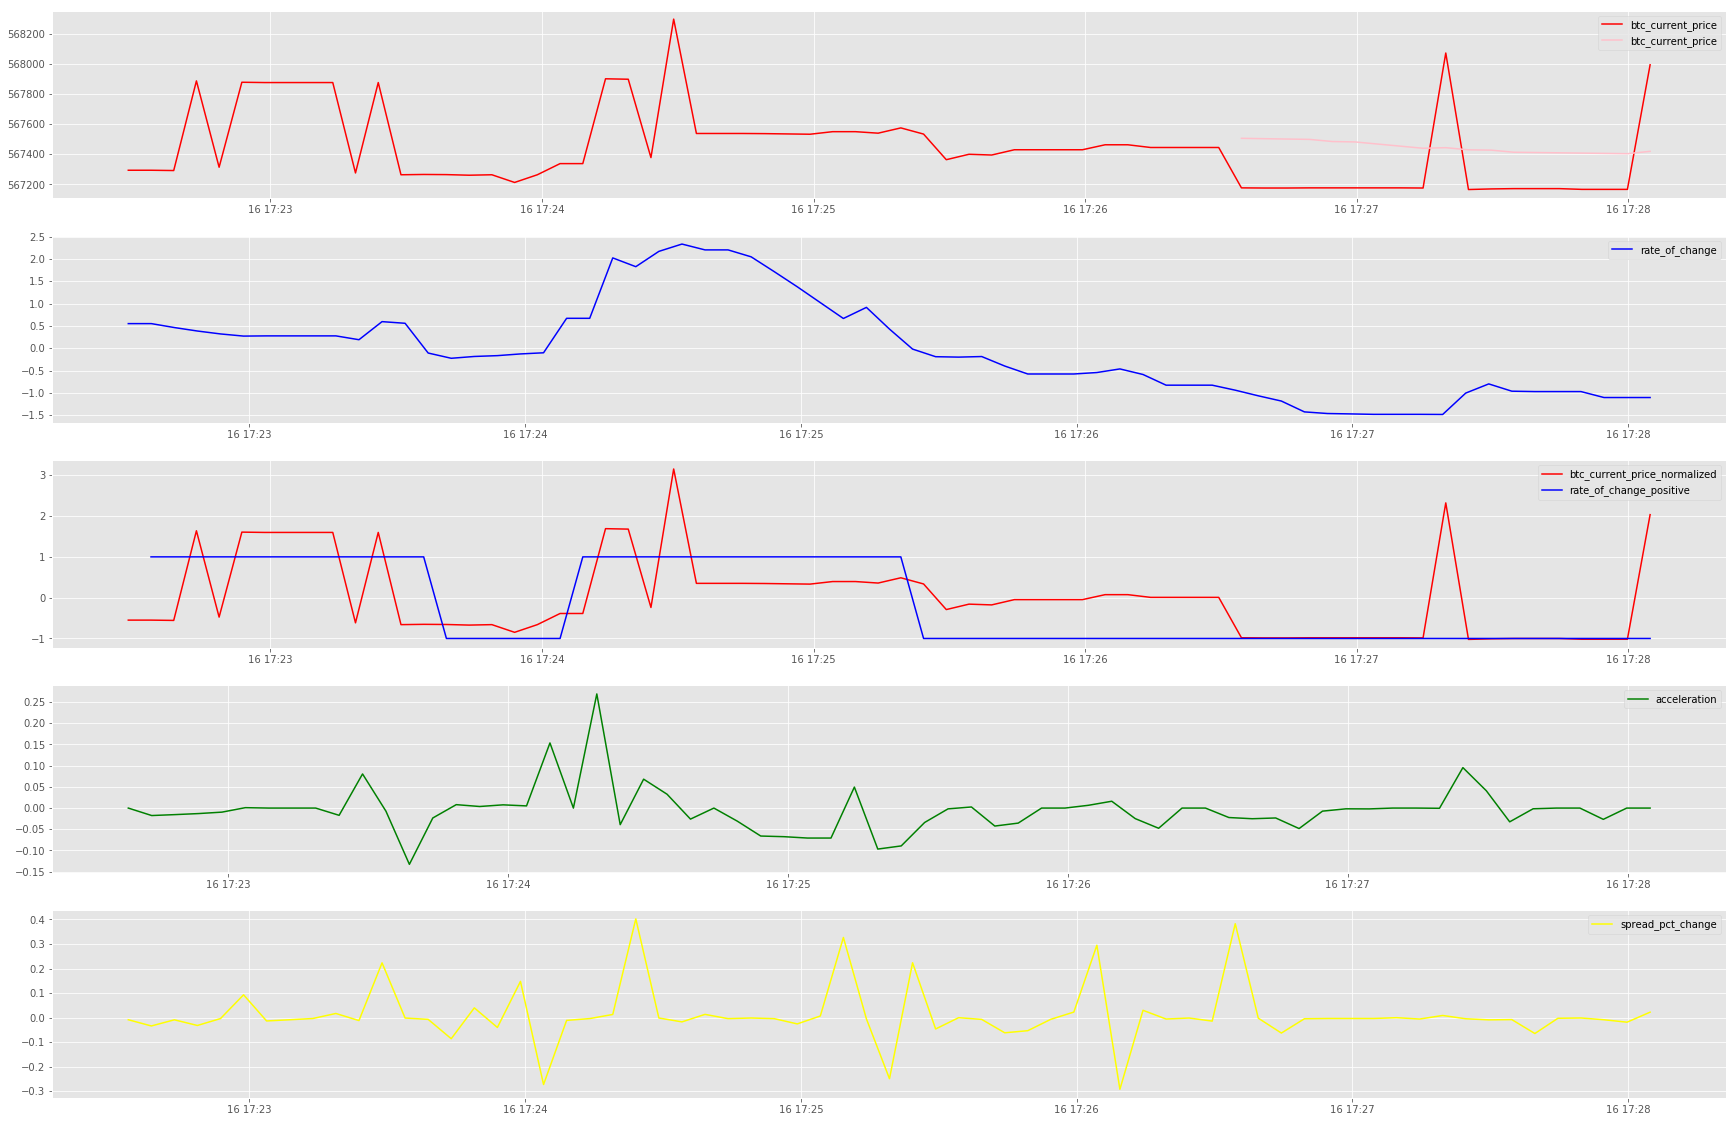

In [14]:
num = 5
fig, axes = plt.subplots(nrows=num, ncols=1, figsize=(30, 20), sharex=True)
plt.subplot(num,1,1)
plt.plot(df.datetime, df.btc_current_price, color='r')
plt.plot(df.datetime, df.btc_current_price.rolling(50).mean(), color='pink')
plt.legend()
#ax1.plot(df.datetime, df.ask_low, color='cyan', linestyle='--')
#ax1.plot(df.datetime, df.bid_high, color='magenta', linestyle='--')
#ax2.plot(df.datetime, df.spread, color='gray')
#ax1.scatter(df.datetime, df.bid_price, color='black')
plt.subplot(num,1,2)
plt.plot(df.datetime, df.rate_of_change, color='b')
plt.legend()
plt.subplot(num,1,3)
plt.plot(df.datetime, df.btc_current_price_normalized, color='r')
plt.plot(df.datetime, df.rate_of_change_positive, color='b')
plt.legend()
plt.subplot(num,1,4)
plt.plot(df.datetime, df.acceleration, color='g')
#plt.yscale('log')
plt.legend()
plt.subplot(num,1,5)
plt.plot(df.datetime, df.spread_pct_change, color='yellow')
plt.legend()
#plt.plot(df.datetime, df.spread_pct_change())
plt.show()

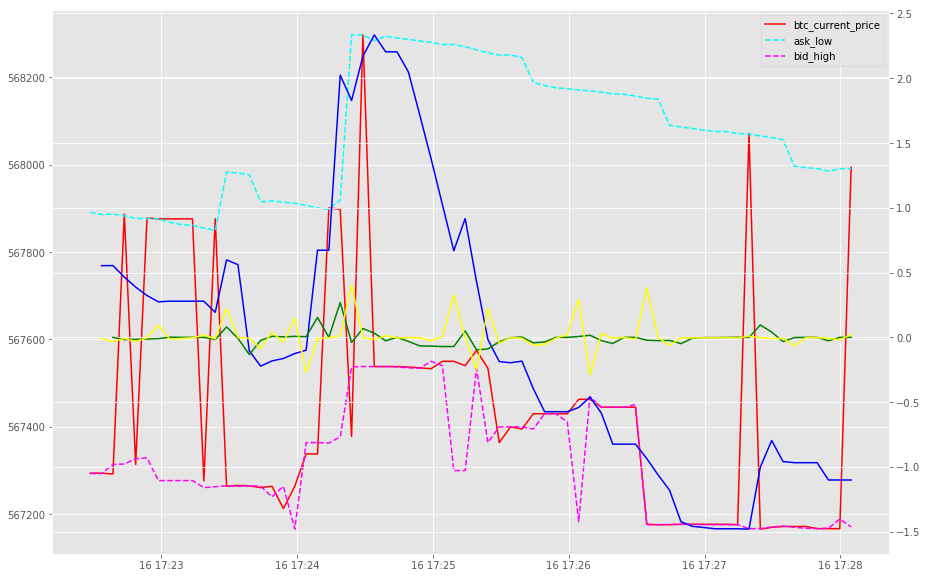

In [15]:
fig, ax1 = plt.subplots(figsize=(15,10))
ax2 = ax1.twinx()
ax1.plot(df.datetime, df.btc_current_price, color='r')
ax1.plot(df.datetime, df.ask_low, color='cyan', linestyle='--')
ax1.plot(df.datetime, df.bid_high, color='magenta', linestyle='--')
ax1.legend()
#ax2.plot(df.datetime, df.spread, color='gray')
#ax1.scatter(df.datetime, df.bid_price, color='black')
ax2.plot(df.datetime, df.rate_of_change, color='b')
ax2.plot(df.datetime, df.acceleration, color='g')
ax2.plot(df.datetime, df.spread_pct_change, color='yellow')
#ax2.legend()
plt.show()

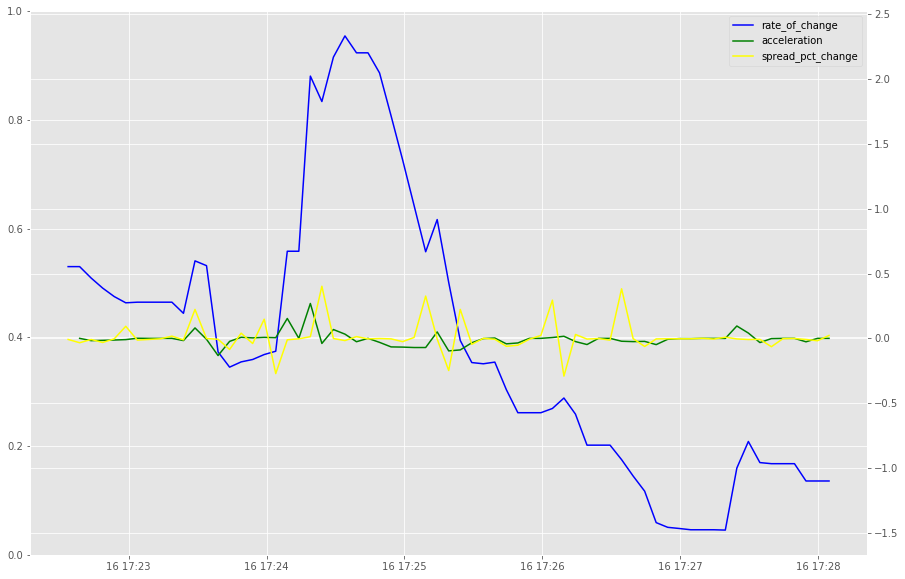

In [16]:
fig, ax1 = plt.subplots(figsize=(15,10))
ax2 = ax1.twinx()
#ax1.plot(df.datetime, df.btc_current_price, color='r')
#ax2.plot(df.datetime, df.spread, color='gray')
#ax1.scatter(df.datetime, df.bid_price, color='black')
ax2.plot(df.datetime, df.rate_of_change, color='b')
ax2.plot(df.datetime, df.acceleration, color='g')
ax2.plot(df.datetime, df.spread_pct_change, color='yellow')
ax2.legend()
plt.show()

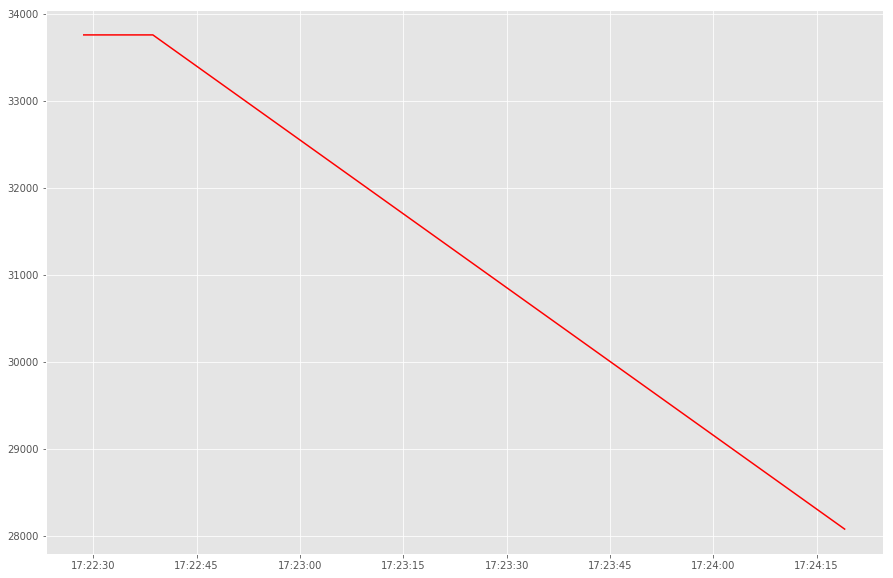

In [22]:
df_cash = df[df.position == 0]
fig, ax1 = plt.subplots(figsize=(15,10))
ax1.plot(df_cash.datetime, df_cash.cash, color='r')